# Tarea E-3. 

**Autores**: Jesús Martínez Leal y Carlos Sánchez Polo

**Enunciado**:

El algoritmo DOMINANT de `detección de anomalías` en grafos está basado en las ideas de redes convolucionales (GNN) y autoencoders (GAE) de los grafos.

- Introduce teóricamente las redes convolucionales en grafos (GNN).
- Aplica las GNN en ejemplos sencillos en los que se muestren los conceptos anteriormente introducidos.

In [1]:
import torch
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import os

## Conceptos previos

### Introducción a los grafos

Los grafos son estructuras matemáticas que nos permiten representar y modelar relaciones entre diversas entidades. En su forma más básica, un grafo está compuesto por un conjunto de `nodos` (también llamados vértices) unidos por enlaces llamados `aristas` (también llamados bordes). Típicamente, un grafo se representa como diagrama como un conjunto de círculos para los vértices, unido por líneas o curvas para las aristas. 

<figure align="center">
  <img src="./data/graph-theory-in-discrete-mathematics.png" alt="Figura de un grafo">
  <figcaption>Figura 1: Representación de un grafo.</figcaption>
</figure>

Los enlaces pueden ser `no dirigidos` o `dirigidos`, lo que significa que pueden representar relaciones unidireccionales o bidireccionales entre los nodos, respectivamente. Ejemplos de esto serían:

- **Enlaces no dirigidos**. Imaginemos que tenemos un grafo con vértices representando a personas en una fiesta y existe una conexión si dos personas se dan la mano. Las conexiones serán efectivamente no dirigidas dada la reprocidad que implica darse la mano.

- **Enlaces dirigidos**. Imaginemos ahora que el grafo cuenta con vértices representando las conexiones entre distintas estaciones de tren. Podría darse el caso que la estación A estuviera conectada con la estación B directamente, pero que no fuera al contrario.

<div style="text-align:center;">
  <figure style="display:inline-block;">
    <img src="./data/conexion_no_dirigida.png" alt="Conexión no dirigida">
    <figcaption>Figura 2: Enlace no dirigido.</figcaption>
  </figure>
  <figure style="display:inline-block;">
    <img src="./data/conexion_dirigida.png" alt="Conexión dirigida">
    <figcaption>Figura 3: Enlace dirigido.</figcaption>
  </figure>
</div>

Formalmente, un grafo $G$ es un `par ordenado` $G = (V, E)$, donde $V$ es un conjunto de nodos y $E$ un conjunto de aristas que relacionan estos. En un `grafo no dirigido` encontramos que todos los enlaces son no dirigidos, sucediendo justamente lo opuesto en un `grafo dirigido`. Por otra parte,  un `grafo mixto` permite los dos tipos de enlaces en su estructura, siendo un caso más general de los anteriores.




Cabe mencionar que los elementos individuales de cada grafo pueden almacenar información adicional:

- Información en nodos. La información almacenada en cada nodo puede incluir atributos para caracterizar mejor la entidad que representa.
- Información en enlaces. La información aquí puede incluir atributos que describen la naturaleza de la relación entre los nodos. Puede incluir pesos para la ponderar la fuerza, distancia o similitud entre los nodos conectados (`grafo ponderado`).
- Información en el grafo en su conjunto. Información como el número total de nodos y aristas, densidad del grafo, etc.

<figure align="center">
  <img src="./data/information_graphs.png" alt="Información incrustada en un grafo">
  <figcaption>Figura 4: Información incrustada dentro de los elementos de un grafo.</figcaption>
</figure>

<figure align="center">
  <img src="./data/weighted_graph2.png" alt="Grafo ponderado">
  <figcaption>Figura 5: Grafo ponderado.</figcaption>
</figure>



Los grafos constituyen herramientas poderosas y versátiles que se utilizan en amplia variedad de campos, debido a su capacidad de modelar y representar una amplia gama de relaciones y estructuras complejas.

Puede resultar sorprendente, pero ¡los grafos son capaces de modelar objetos tan comunes como `imágenes` y `texto`!

### Introducción a las redes neuronales (convolucionales se detalla algo más)

Las `redes neuronales` son modelos computacionales inspirados en el cerebro humano que se utilizan para aprender y realizar tareas específicas. Han tenido un impacto muy significativo en la historia de la humanidad, permitiendo mejoras drásticas en muchas áreas de tecnología, medicina, industria, investigación científica...

Consisten en un conjunto de unidades llamadas `neuronas` conectadas entre sí. La información de entrada atraviesa la red sometiéndose a diversas operaciones, produciendo valores de salida.

<figure align="center">
  <img src="./data/neural_network_basic.png" alt="Red neuronal básica">
  <figcaption>Figura 5: Esquema básico de una red neuronal.</figcaption>
</figure>

La fuerza de conexión entre las distintas neuronas se ve modelada por los `pesos` de la red, parámetros del modelo que se van ajustando durante el `proceso de entrenamiento`.

Típicamente, las neuronas están distribuidas en capas, permitiendo una distribución de la tarea a ejecutar en un problema determinado para el objetivo a buscar. Se tienen la `capa de entrada`, `capas ocultas` y la `capa de salida`.

**FUNCIONAMIENTO BÁSICO**

Existen muchos tipos diversos de redes neuronales y de particularidades, pero a continuación se describe la base del entrenamiento de una red neuronal.

- `Paso hacia delante` (Forward Pass).

Durante esta etapa los datos se propagan hacia delante. El recorrido empieza desde la capa de entrada y continúa por las capas ocultas, donde se sigue la siguiente relación para determinar cómo se transmite la información entre neuronas de una capa anterior a una posterior.

$$x_{j}^{l + 1} = f (\sum_{i} w_{ij}^l x_{i} ^l)$$ 

donde $l$ designa la capa en cuestión, $j$ es el índice que va sobre las neuronas de la capa $l + 1$ y $i$ el que va sobre las neuronas de la capa $l$: $w_{ij}^l$ es pues el peso que conecta la neurona i-ésima de la capa $l$ con la neurona j-ésima de la capa $l + 1$. Por otra parte, $f$ es una función de `activación` generalmente no lineal, permitiendo enriquecer la captura de estructuras en los datos por parte del modelo.

La capa de salida finalmente permite sacar del modelo los valores finales que nos interesen en nuestra tarea.

- `Función de pérdida`.

Después del paso hacia delante, la salida de la red se compara con los valores verdaderos (esto es si es problema supervisado) usando una función de pérdida (`loss function`), dependiente del problema que queremos tratar.

- `Paso hacia atrás` (Backward pass).

Durante esta etapa la red va actualizando sus pesos tratando de minimizar la función de pérdida. Para ello, se calculan primeramente los gradientes de la función de pérdida respecto a los pesos de la red, haciendo uso de la *regla de la cadena* que todos aprendimos una vez en cálculo. Posteriormente, se ajustan los pesos en la dirección que se minimice dicha función.

Todo esto se realiza de manera iterativa, siguiendo las instrucciones dadas por el usuario (`hiperparámetros`, `callbacks`, `algoritmos de optimización`, etc).

**TIPOS BÁSICOS DE REDES NEURONALES**

Hay una cantidad muy grande de tipos de redes neuronales, pero aquí se muestra la idea básica de los más utilizados.

1. `Redes neuronales de avance (o de propagación hacia delante).`

Las conexiones entre neuronas **no** forman un ciclo en este tipo. La información discurre desde la capa de entrada hasta la capa de salida.

- Perceptrón simple (una sola capa).

Este es el modelo más simple de red neuronal de avance. No contiene una capa oculta.

<figure align="center">
  <img src="./data/perceptron_simple.gif" alt="Perceptrón simple">
  <figcaption>Figura 6: Esquema de un perceptrón simple.</figcaption>
</figure>

- Perceptrón multicapa (MLP).

Este es el modelo más común a la hora de introducir las redes neuronales: básicamente tenemos los distintos tipos de capas vistas anteriormente.

<figure align="center">
  <img src="./data/mlp_image.png" alt="Perceptrón multicapa">
  <figcaption>Figura 7: Esquema de un perceptrón multicapa sencillo.</figcaption>
</figure>

- Redes neuronales convolucionales (CNN).

Este tipo de redes son especialmente conocidas por su rendimiento excelente para extraer características en audio y (sobre todo) de imágenes. Esto enfoca la arquitectura para configurarse de tal manera que se adapte mejor a la necesidad de tratar con este tipo de datos.

Las neuronas en las capas dentro de las CNN están organizadas en tres dimensiones: la dimensionalidad espacial de la entrada (altura y anchura) y la profundidad. Esta profundidad no tiene que ver con el número total de capas dentro de la red, sino a la tercera dimensión de un `volumen de activación`. 

Poseen tres tipos de capas distinguidas: las `capas convolucionales`, las capas `pooling` (para submuestreo) y las capas `fully-connected` (completamente conectadas).

<figure align="center">
  <img src="./data/cnn_architecture.png" alt="Arquitectura CNN simple">
  <figcaption>Figura 8: Arquitectura de una red convolucional simple.</figcaption>
</figure>

`Capas convolucionales`: van a determinar la salida de neuronas que están conectadas a regiones locales de la entrada a través del cálculo del producto escalar entre sus pesos y la región conectada al volumen de entrada. En otras palabras, estas capas aplican filtros o `kernels` (se aprenden solos) a la entrada para detectar características relevantes de los datos, como bordes, texturas o patrones específicos. Cada neurona en esta capa está conectada pues solo a una pequeña región de la imagen de entrada, lo que permite que la red capture características locales y las comparta en toda la imagen (todo esto asociado a tener un número mucho menor de parámetros que los que habría en una capa completamente conectada). 

Concretamente, el kernel se aplica a un área de la imagen y se calcula un producto escalar entre los píxeles de entrada y el filtro. Se produce un mapa de activación (o de características), en el que básicamente se resaltan las áreas donde se encuentran las características interesantes que el kernel buscaba. Este puede visualizarse posteriormente.

Hay 3 hiperparámetros muy importantes que afectarán al tamaño de salida:

- **Número de filtros**: afecta a la profundidad de salida. Por ejemplo, tres filtros distintos darían tres mapas de características diferentes.
- **Stride (paso, en español)**: es el número de píxeles que el kernel se mueve sobre la matriz de input. Un stride mayor, da un output menor.
- **Zero-padding**: usualmente se utiliza cuando los filtros no "caben" en la imagen de entrada. Esto hace que todos los elementos que caen fuera se pongan como 0. Están los tipos `valid`, `same` y `full`.

Después de cada operación de convolución, se suele aplicar una transformación ReLU al mapa de activación, introduciendo no linealidad.

`Capas de pooling`: hacen submuestreo para la dimensionalidad espacial de una entrada, reduciendo así el número de parámetros. De manera similar a la capa convolucional, se tiene a un filtro barriendo toda la entrada, pero la diferencia es que este filtro no tiene pesos. En su lugar, el kernel aplica una función de agregación a los valores dentro del `campo receptivo` (trozo que ve cada neurona). Están los tipos `max` (donde se coge el máximo) y `average` (donde se toma el promedio).

`Capas fully-connected`: tienen la misma tarea que en las redes neuronales convencionales. Esta capa realiza la tarea de clasificación basada en las características extraídas a través de las capas anteriores y sus diferentes filtros. Mientras que las capas convolucionales y de agrupación tienden a utilizar funciones ReLu, las capas FC suelen aprovechar una función de activación softmax para clasificar adecuadamente las entradas, produciendo una probabilidad de 0 a 1.

## Matrimonio entre los grafos y las redes neuronales (convolucionales)

### Conceptos teóricos

Los `Graph Neural Networks` (GNN) representan una de las arquitecturas que más cautivadoras y de evolución rápida dentro del panorama del aprendizaje profundo. Como modelos de aprendizdaje profundo **diseñados para procesar datos estructurados en forma de grafos**, las GNNs aportan una versatilidad notable y capacidades de aprendizaje potentes. Entre los diversos tipos de GNNs, las Redes Convolucionales de Grafos (GCNs, por sus siglas en inglés), han surgido como el modelo más prevalente y ampliamente utilizado. Estas son innovadoras puesto que permiten aprovechar tanto las características de un nodo como su localidad para hacer predicciones, proporcionando una manera efectiva de manejar datos estructurados en forma de grafo.

En el *análisis de imágenes*, las GNN se emplean para modelar relaciones espaciales y semánticas entre los elementos de una imagen representados como un grafo. Estas redes son incluso capaces de capturar la estructura jerárquica e interacciones entre las regiones de la imagen, lo que mejora el rendimiento en tareas como segmentación semántica o la detección de objetos.

**FUNCIONAMIENTO BÁSICO DE LAS GNN (particularizamos fórmulas a GCN)**

El funcionamiento básico se basa en el concepto de "propagación de mensajes". Los nodos del grafo podrán comunicarse entre sí al pasar mensajes a lo largo de los enlaces, actualizando sus "embeddings" en función de la información agregada. El proceso consta de dos pasos principales: la computación de mensajes, donde cada nodo envía un mensaje a sus vecinos, y la agregación de mensajes, donde cada nodo recopila los mensajes de sus vecinos y los combina para obtener una nueva representación de sí mismo.

<figure align="center">
  <img src="./data/message_passing.jpg" alt="Paso de mensajes">
  <figcaption>Figura 9: Paso de mensajes.</figcaption>
</figure>

En cada capa de la red se hará un cálculo de una representación para cada nodo del grafo, combinando la información que otorgan sus vecinos. Esto se logra a partir de una combinación lineal de las representaciones de estos (lo que sería algo similar a una convolución, en este contexto) y una función de activación no lineal. Matemáticamente, esto puede ponerse como:

$$h_i = \sum_{j \in \mathcal{N}_i} \textbf{W} x_j$$

donde $h_i, x_j$ son `vectores de representación de los nodos`*, **W** es la matriz de pesos (única y compartida para cada nodo).

Estos vectores de representación de los nodos se eligen dependiendo de la aplicación: pueden ser *word vectors* si trabajamos con bases de conocimiento, *valores de píxeles* si trabajamos con imágenes...

Estrictamente, podemos extender esta notación para que nos sirva si hay capas sucesivas, añadiendo también la función de activación explícitamente ya.

$$h_{i}^{l + 1} = f\left(\sum_{j \in \mathcal{N}_i} \frac{1}{c_{ij}} \textbf{W} h_{j}^{l}\right)$$

donde $c_{ij}$ es una normalización que se implementa para asegurar que tenemos un rango similar de valores para todos los nodos (ya que habrá nodos con un montón de vecinos y otros más solos que la una). Normalmente, se toma $c_{ij} = \sqrt{\textrm{deg}(i)} \sqrt{\textrm{deg}(j)}$, siendo $\textrm{deg}()$ la función que cuenta el número de conexiones en un nodo.

De forma matricial la cosa suele ser más elegante, no siendo una excepción esta vez:

$$H^{l + 1} = f(\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{l} \textbf{W}^{l})$$

donde $H$ es la matriz con las representaciones de los nodos, $X$ es la matriz de características de los nodos, $\hat{A}$ es la matriz de adyacencia, $\hat{D}$ es la matriz *degree* del grafo y $W$ es la matriz de pesos entrenables.

<figure align="center">
  <img src="./data/adjacency_matrix.png" alt="Matriz de adyacencia">
  <figcaption>Figura 10: Matriz de adyacencia, esquema para entender el concepto.</figcaption>
</figure>

**Nota**: En los grafos del mundo real, la mayoría de nodos están conectados solo con unos cuantos, resultando esto en un número enorme de ceros en la matriz de adyacencia. Almacenar tantos ceros simplemente no es eficiente, por lo que se utilizan otros métodos como el de **coordinate list** (COO), que permite almacenar solo elementos distintos de 0.

<figure align="center">
  <img src="./data/coo.gif" alt="COO format">
  <figcaption>Figura 11: COO format.</figcaption>
</figure>

Las GCNs generalizan el concepto de convoluciones al tipo de datos estructurados en grafos, permitiendo aplicar operaciones convolucionales a nodos y relaciones en el grafo, en lugar de a píxeles en una cuadrícula como acostumbran las redes convolucionales convencionales. La sucesión de `capas adicionales` hará que ese proceso de propagación de mensajes y agregación de información que hablamos anteriormente lleve a una captura de información más compleja y de mayor alcance en el grafo.

### Implementación de un código básico | Clasificación de nodos

Se hará uso del dataset `Zachary's karate club`.

<figure align="center">
  <img src="./data/zachary_dataset.png" alt="Zachary's karate club graph">
  <figcaption>Figura 12: Zachary's karate club graph.</figcaption>
</figure>

Este dataset muestra las relaciones formadas en un club de Karate observadas por Wayne W.Zachary en los años 70. Es una especie de "red social", donde cada nodo representa a un miembro y donde los enlaces representan interaciones ocurridas fuera del entorno del club.

En nuestro caso, los miembros del club están repartidos en 4 grupos. Nuestra tarea será la de asignar el grupo correcto para cada miembro (lo que sería una **clasificación de nodo**).

Importamos el dataset de la librería de `torch_geometric`.

In [2]:
from torch_geometric.datasets import KarateClub

Inspeccionemos un poco nuestro dataset para ver qué ofrece.

In [3]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Número de grafos: {len(dataset)}')
print(f"Número de características: {dataset.num_features}")
print(f"Número de clases: {dataset.num_classes}")

Dataset: KarateClub():
Número de grafos: 1
Número de características: 34
Número de clases: 4


Vemos que el dataset cuenta solamente con un grafo, donde cada nodo tiene un vector de características de dimensionalidad igual a 34 y perteneciendo a una de las 4 clases presentes.

Accedamos explícitamente al dataset.

In [4]:
print("KarateClub Graph", dataset[0])
print("\n")
data = dataset[0] # datos en sí

# Matriz de características de los nodos
print(f"x = {data.x.shape}")
print(data.x)
print("\n")

# Conectividad del grafo
print(f"edge_index = {data.edge_index.shape}")
print(data.edge_index)
print("\n")

# Etiquetas de los nodos
print(f"y = {data.y.shape}")
print(data.y)
print("\n")

# ¿Qué nodos se usan para entrenamiento?

print(f"train_mask = {data.train_mask.shape}")
print(data.train_mask)

KarateClub Graph Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32,

Vemos que la matriz de características de los nodos `x` es la matriz Identidad. Esto es así porque no contienen los nodos más información adicional como podría ser la edad, grupo sanguíneo, etc. La clasificación de los nodos se tendrá que realizar puramente por sus conexiones.

Por otra parte, la conectividad del gráfico viene aquí almacenada en dos listas en las que se muestran las conexiones mirando el par `(data.edge_index[0][i], data.edge_index[1][i])` (nodo de salida, nodo de entrada). Hay un total de 156 conexiones en total (donde se tiene en cuenta que una bidireccional cuenta como 2).

Por último, `train_mask` nos informa sobre los nodos que se utilizan para el entrenamiento (valor en `True`) y los que no (valor en `False`).

Además de estas propiedades, nuestro objeto `Data` contiene más información útil.

In [5]:
# ¿Es dirigido el grafo?

print(f"directed = {data.is_directed()}")

# ¿Tiene nodos aislados?

print(f"contains_isolated_nodes = {data.has_isolated_nodes()}")

# ¿Tiene bucles?

print(f"contains_self_loops = {data.has_self_loops()}")

directed = False
contains_isolated_nodes = False
contains_self_loops = False


Nuestro grafo es efectivamente dirigido, no tiene nodos aislados y tampoco bucles.

**CONVERSIÓN A LIBRERÍA NETWORKX**

Nos interesa a continuación convertir nuestro grafo que ofrece la librería `Pytorch Geometric` a otra llamada `NetworkX`, que es particularmente interesante por la posibilidad que ofrece de visualizar el grafo.

In [6]:
from torch_geometric.utils import to_networkx

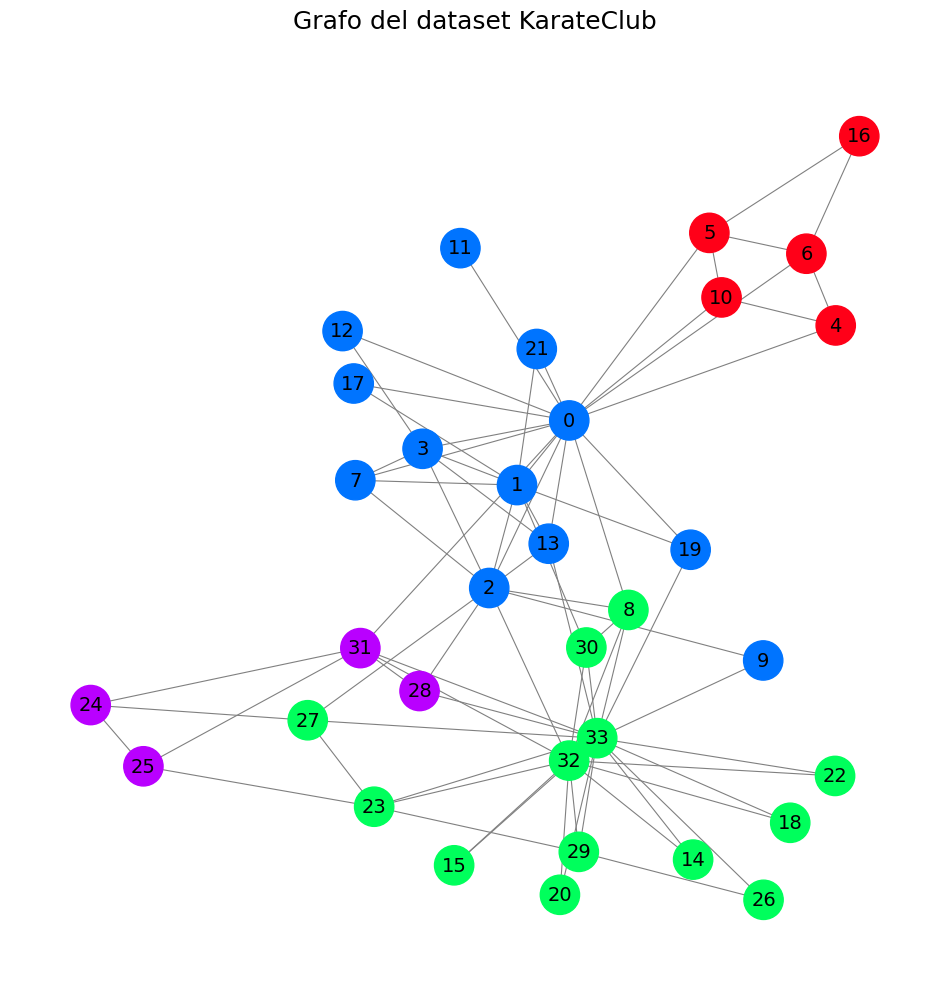

In [7]:
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(12, 12))
plt.axis('off')


nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 with_labels=True,
                 node_size=800,
                 node_color=data.y,
                 cmap="hsv",
                 vmin=-2,
                 vmax=3,
                 width=0.8,
                 edge_color="grey",
                 font_size=14,
                 font_color="black"
                )
plt.title('Grafo del dataset KarateClub', fontsize = 18, pad = 20)

plt.show()

**IMPLEMENTACIÓN DE UN GCN**

`Pytorch Geometric` nos provee con la función `GCNConv` que implementa una **capa de grafo convolucional**.

Definiremos un modelo sencillo que nos permita tener una visión sencilla. Concretamente, tendremos una red de grafos convolucionales que consista en:

- Una sola capa GCN (con una función de activación ReLU tras ella).
- Una capa de salida lineal.

La capa lineal nos permitirá hacer la selección del valor de categoría en la predicción.

In [8]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [9]:
# Creamos la clase GCN que hereda de torch.nn.Module y define la arquitectura de la red

class GCN(torch.nn.Module):
    
    # Definimos el constructor de la clase
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)
        
    # Definimos el método forward
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
    
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


Si añadiésemos más capas GCN empezaríamos a tener en cuenta a vecinos de vecinos... Sin embargo, la agregación se volvería tan intensa que todos los *Embeddings* acabarían muy similares. Esto se conoce con el nombre de sobresuavizado.

Definimos también la función de pérdida que usaremos, además del optimizador.

Se tomará la cross-entropy loss ya que estamos en una tarea de clasificación multi-clase, así como Adam como es habitual.

In [10]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

Nos definimos nuestro bucle de training, donde se harán las comparaciones con los resultados verdaderos de eteiquetas. Se instaura aquí también el método de *backpropagation* que nos permite recuperar los pesos adecuados para el modelo.

In [11]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

In [12]:
# Sacar precisión

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Inicializamos las listas para almacenar los datos de la animación
embeddings = []
losses = []
accuracies = []
outputs = []

totalEpochs = 301

# Entrenamos el modelo
for epoch in range(totalEpochs):
    #  Reset gradientes
    optimizer.zero_grad()
    # Forward pass
    h, z = model(data.x, data.edge_index) # h: embeddings, z: logits
    # Calcular la pérdida
    loss = criterion(z, data.y)
    # Calcular la precisión
    acc = accuracy(z.argmax(dim=1), data.y)
    # Backward pass
    loss.backward()
    # Actualizar los pesos
    optimizer.step()
    
    # Almacenar los datos de la animación
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    
    # Imprimir resultados cada 10 épocas
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.32 | Acc: 17.65%
Epoch  10 | Loss: 1.25 | Acc: 38.24%
Epoch  20 | Loss: 1.16 | Acc: 38.24%
Epoch  30 | Loss: 1.06 | Acc: 47.06%
Epoch  40 | Loss: 0.93 | Acc: 67.65%
Epoch  50 | Loss: 0.77 | Acc: 73.53%
Epoch  60 | Loss: 0.62 | Acc: 94.12%
Epoch  70 | Loss: 0.48 | Acc: 97.06%
Epoch  80 | Loss: 0.36 | Acc: 100.00%
Epoch  90 | Loss: 0.27 | Acc: 100.00%
Epoch 100 | Loss: 0.21 | Acc: 100.00%
Epoch 110 | Loss: 0.16 | Acc: 100.00%
Epoch 120 | Loss: 0.13 | Acc: 100.00%
Epoch 130 | Loss: 0.11 | Acc: 100.00%
Epoch 140 | Loss: 0.09 | Acc: 100.00%
Epoch 150 | Loss: 0.07 | Acc: 100.00%
Epoch 160 | Loss: 0.06 | Acc: 100.00%
Epoch 170 | Loss: 0.05 | Acc: 100.00%
Epoch 180 | Loss: 0.04 | Acc: 100.00%
Epoch 190 | Loss: 0.04 | Acc: 100.00%
Epoch 200 | Loss: 0.03 | Acc: 100.00%
Epoch 210 | Loss: 0.03 | Acc: 100.00%
Epoch 220 | Loss: 0.03 | Acc: 100.00%
Epoch 230 | Loss: 0.02 | Acc: 100.00%
Epoch 240 | Loss: 0.02 | Acc: 100.00%
Epoch 250 | Loss: 0.02 | Acc: 100.00%
Epoch 260 | Loss: 0.

Hemos obtenido una precisión del 100% finalmente en nuestro conjunto de entrenamiento (el cual era todo el dataset por simplicidad). Se ha conseguido asociar cada nodo con su grupo.

Se muestra a continuación una animación donde se colorean los distintos nodos según es la predicción en las distintas épocas.

In [13]:
from matplotlib import animation
from IPython.display import HTML
plt.rcParams["animation.bitrate"] = 3000 # Ajustar la tasa de bits para la animación

In [19]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=True,
                     node_size=600,
                     node_color=outputs[i],
                     cmap="hsv",
                     vmin=-2,
                     vmax=3,
                     width=0.8,
                     edge_color="grey",
                     font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(8, 6))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=800, repeat=True)

# Guardar la animación con resolución ajustada


if os.path.exists('./data/zachary_graph_anim.gif'):
    os.remove('./data/zachary_graph_anim.gif')
    
anim.save('./data/zachary_graph_anim.gif', writer='pillow')

plt.close()  # Cierra la figura para evitar la imagen estática adicional

HTML('<img src="./data/zachary_graph_anim.gif">')

Las primeras predicciones son completamente aleatorias.

**¿Qué está aprendiendo exactamente la capa GCN?**

Agregando características (como se vio en la sección teórica) de los nodos vecinos permite a la red neuronal de grafos aprender un vector de representación para cada nodo. En nuestro modelo, la última capa que pusimos lineal lo único que aprende es a mapear esa representación (o **embedding**) a las mejores clasificaciones.

¿Qué forma tienen los embeddings?

In [15]:
# Embeddings finales

final_embeddings = embeddings[-1]
print(f'Embeddings finales: {final_embeddings.shape}')
print(final_embeddings)

Embeddings finales: torch.Size([34, 3])
tensor([[3.6660e-02, 2.7568e+00, 0.0000e+00],
        [0.0000e+00, 1.9593e+00, 0.0000e+00],
        [3.3379e-06, 1.6848e+00, 2.6589e-01],
        [0.0000e+00, 1.9285e+00, 0.0000e+00],
        [2.1779e+00, 1.8269e+00, 8.0764e-05],
        [2.4295e+00, 2.0933e+00, 0.0000e+00],
        [2.3839e+00, 2.1172e+00, 0.0000e+00],
        [0.0000e+00, 1.6498e+00, 0.0000e+00],
        [1.1995e+00, 2.1689e-01, 1.4478e+00],
        [7.0917e-02, 1.2846e+00, 2.8116e-01],
        [2.3067e+00, 1.7762e+00, 0.0000e+00],
        [2.2453e-04, 1.6770e+00, 9.1493e-05],
        [0.0000e+00, 1.6694e+00, 6.1989e-06],
        [0.0000e+00, 1.4518e+00, 1.6145e-01],
        [1.4311e+00, 1.3882e-01, 1.6315e+00],
        [1.3533e+00, 9.6300e-02, 1.6600e+00],
        [2.3350e+00, 1.9897e+00, 6.6320e-02],
        [1.8555e-04, 1.6928e+00, 7.2777e-05],
        [1.3678e+00, 9.4151e-02, 1.6550e+00],
        [4.6820e-02, 1.3823e+00, 1.1185e-01],
        [1.4822e+00, 1.6761e-01, 1.7277e

Vemos que tenemos al final dimensionalidad 3 para los embeddings, puesto que así se ha elegido. Esto se elige de manera conveniente para ahora poder representar su evolución en un espacio tridimensional.

In [16]:
# Tener el embedding en la época 0
embed = h.detach().cpu().numpy() 

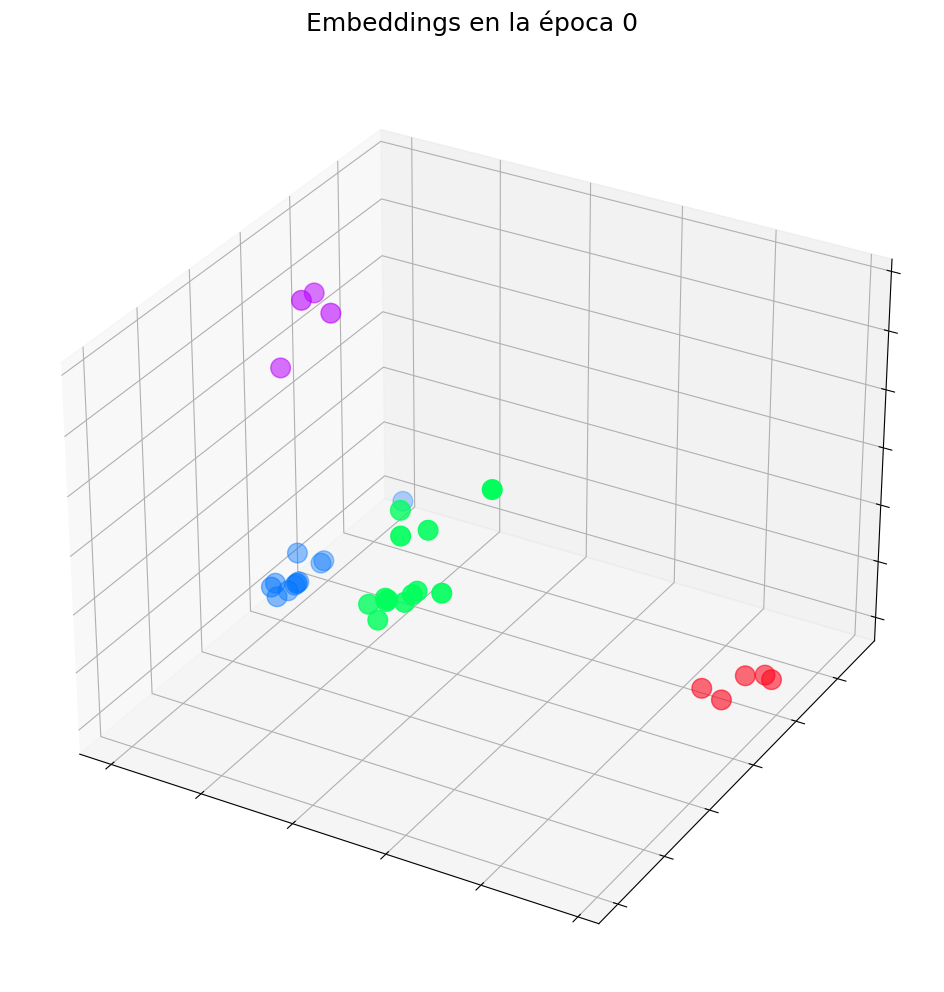

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.title('Embeddings en la época 0', fontsize=18, pad=20)
plt.show()

In [18]:
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 300, 10), interval=800, repeat=True)


if os.path.exists('./data/zachary_embeddings_anim.gif'):
    os.remove('./data/zachary_embeddings_anim.gif')
    
anim.save('./data/zachary_embeddings_anim.gif', writer='pillow')

plt.close()

HTML('<img src="./data/zachary_embeddings_anim.gif">')

Nuestra red de grafos convolucionales ha conseguido aprender los embeddings que permiten agrupar nodos similares en distintos clusters.

### Aplicación en detección de anomalías

Mencionar funcionamiento de algoritmo DOMINANT de manera básica?

## Estado actual de las GNN / Visión a futuro?

mira el ti ef yi